In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/viral-tweets/Dataset/solution_format.csv
/kaggle/input/viral-tweets/Dataset/Tweets/test_tweets_vectorized_media.csv
/kaggle/input/viral-tweets/Dataset/Tweets/train_tweets_vectorized_text.csv
/kaggle/input/viral-tweets/Dataset/Tweets/test_tweets_vectorized_text.csv
/kaggle/input/viral-tweets/Dataset/Tweets/test_tweets.csv
/kaggle/input/viral-tweets/Dataset/Tweets/train_tweets.csv
/kaggle/input/viral-tweets/Dataset/Tweets/train_tweets_vectorized_media.csv
/kaggle/input/viral-tweets/Dataset/Users/user_vectorized_profile_images.csv
/kaggle/input/viral-tweets/Dataset/Users/users.csv
/kaggle/input/viral-tweets/Dataset/Users/user_vectorized_descriptions.csv


In [2]:
# surpress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', color_codes=True)
plt.style.use('fivethirtyeight')
%matplotlib inline


In [3]:
# misc libraries
import random
import timeit
import math 
import collections 


# model building
import lightgbm as lgb
import sklearn.metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score,f1_score, confusion_matrix
from sklearn import preprocessing

In [4]:
# Note: this path will be different depending on where you store the dataset
tweets_path = '/kaggle/input/viral-tweets/Dataset/Tweets/'
users_path = '/kaggle/input/viral-tweets/Dataset/Users/'

# Load training datasets
train_tweets = pd.read_csv(tweets_path + 'train_tweets.csv')
train_tweets_vectorized_media = pd.read_csv(tweets_path + 'train_tweets_vectorized_media.csv')
train_tweets_vectorized_text = pd.read_csv(tweets_path + 'train_tweets_vectorized_text.csv')

# Load test dataset
test_tweets = pd.read_csv(tweets_path + 'test_tweets.csv')
test_tweets_vectorized_media = pd.read_csv(tweets_path + 'test_tweets_vectorized_media.csv')
test_tweets_vectorized_text = pd.read_csv(tweets_path + 'test_tweets_vectorized_text.csv')

# Load user dataset
users = pd.read_csv(users_path + 'users.csv')
user_vectorized_descriptions = pd.read_csv(users_path + 'user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(users_path + 'user_vectorized_profile_images.csv')

In [5]:
print("--------Train Tweets----------------")
print("Dimension of Train Tweets : ",train_tweets.shape )
print("Dimension of Train Tweets Vectorized media : ",train_tweets_vectorized_media.shape )
print("Dimension of Train Tweets Vectorized text : ",train_tweets_vectorized_text.shape )

print("\n")

print("--------Test Tweets----------------")
print("Dimension of Test Tweets : ",test_tweets.shape )
print("Dimension of Test Tweets Vectorized media : ",test_tweets_vectorized_media.shape )
print("Dimension of Test Tweets Vectorized text : ",test_tweets_vectorized_text.shape )

print("\n")

print("--------User----------------")
print("Dimension of Users : ",users.shape )
print("Dimension of User vectorized descriptions : ",user_vectorized_descriptions.shape )
print("Dimension of User vectorized profile images : ",user_vectorized_profile_images.shape )


--------Train Tweets----------------
Dimension of Train Tweets :  (29625, 14)
Dimension of Train Tweets Vectorized media :  (21010, 2050)
Dimension of Train Tweets Vectorized text :  (29625, 769)


--------Test Tweets----------------
Dimension of Test Tweets :  (12697, 13)
Dimension of Test Tweets Vectorized media :  (8946, 2050)
Dimension of Test Tweets Vectorized text :  (12697, 769)


--------User----------------
Dimension of Users :  (52, 11)
Dimension of User vectorized descriptions :  (52, 769)
Dimension of User vectorized profile images :  (52, 2049)


**Preprocessing Train Tweets Data**

In [6]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [7]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

In [8]:
# convert floats to ints
cols = ['tweet_hashtag_count', 'tweet_url_count', 'tweet_mention_count']
train_tweets[cols] = train_tweets[cols].applymap(np.int64)
train_tweets[cols].head()

,tweet_hashtag_count,tweet_url_count,tweet_mention_count
0,2,1,0
1,0,1,0
2,2,3,0
3,0,1,1
4,2,1,0


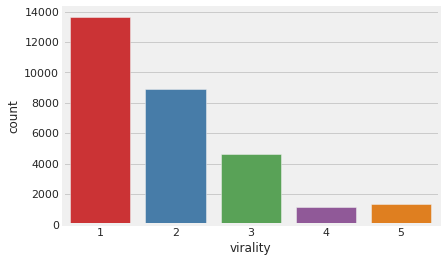

In [9]:
sns.countplot(x = 'virality', data = train_tweets, palette="Set1");

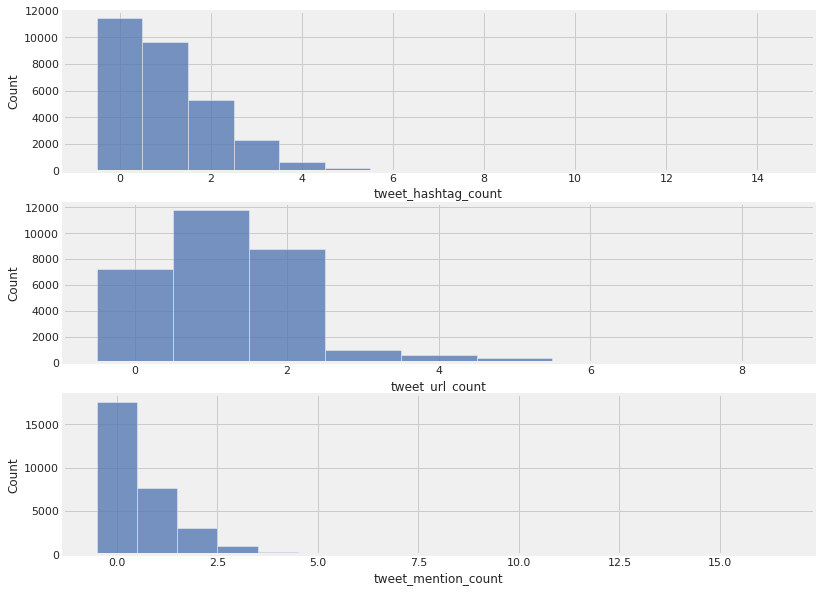

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

sns.histplot(x = 'tweet_hashtag_count', data = train_tweets, discrete = True, ax = axs[0]);
sns.histplot(x = 'tweet_url_count', data = train_tweets, discrete = True, ax = axs[1]);
sns.histplot(x = 'tweet_mention_count', data = train_tweets, discrete = True, ax = axs[2]);

In [11]:
np.sort(train_tweets.tweet_attachment_class.unique())

array(['A', 'B', 'C'], dtype=object)

In [12]:
train_tweets.isnull().sum()

tweet_id                     0
tweet_user_id                0
tweet_created_at_year        0
tweet_created_at_month       0
tweet_created_at_day         0
tweet_created_at_hour        0
tweet_hashtag_count          0
tweet_url_count              0
tweet_mention_count          0
tweet_has_attachment         0
tweet_attachment_class       0
tweet_language_id            0
tweet_topic_ids           4285
virality                     0
dtype: int64

In [13]:
train_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

<AxesSubplot:>

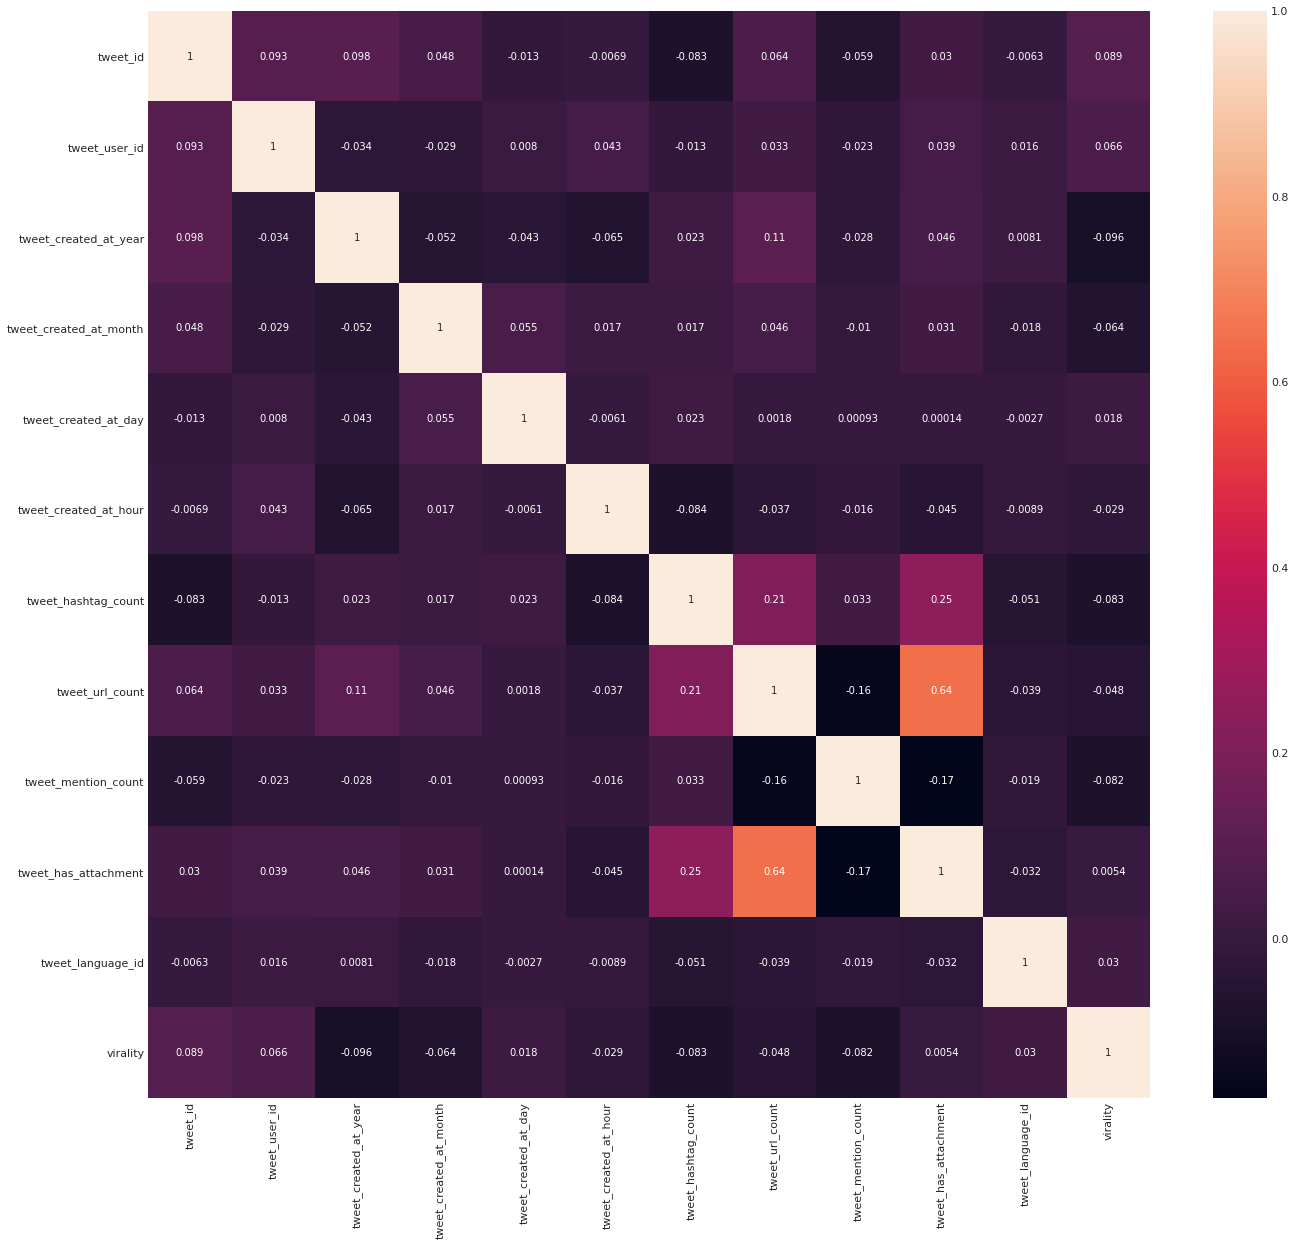

In [14]:
import seaborn as sns
plt.subplots(figsize = (20,20))
sns.heatmap(train_tweets.corr(),annot=True)

In [15]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2,1,0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0,1,0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2,3,0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0,1,1,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2,1,0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [16]:
'''temp = train_tweets.groupby(['tweet_user_id']).agg({'tweet_id':['count'],
                                      'tweet_hashtag_count' : ['mean'],
                                      'tweet_url_count': ['mean'],
                                      'tweet_mention_count': ['mean']            
                                      })
temp.columns = ['_'.join(x) for x in temp.columns]
train_tweets = pd.merge(train_tweets,temp,on=['tweet_user_id'],how='left')'''

"temp = train_tweets.groupby(['tweet_user_id']).agg({'tweet_id':['count'],\n                                      'tweet_hashtag_count' : ['mean'],\n                                      'tweet_url_count': ['mean'],\n                                      'tweet_mention_count': ['mean']            \n                                      })\ntemp.columns = ['_'.join(x) for x in temp.columns]\ntrain_tweets = pd.merge(train_tweets,temp,on=['tweet_user_id'],how='left')"

In [17]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2,1,0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0,1,0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2,3,0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0,1,1,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2,1,0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


In [18]:
topic_ids = (
    train_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [19]:
topic_ids.head(2)

,topic_id_0,topic_id_100,topic_id_101,topic_id_104,topic_id_111,topic_id_112,topic_id_118,topic_id_119,topic_id_120,topic_id_121,...,topic_id_80,topic_id_81,topic_id_82,topic_id_87,topic_id_88,topic_id_89,topic_id_91,topic_id_93,topic_id_98,topic_id_99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,1,1


In [20]:
# year = pd.get_dummies(train_tweets.tweet_created_at_year, prefix='year')
# month = pd.get_dummies(train_tweets.tweet_created_at_month , prefix='month')
# day = pd.get_dummies(train_tweets.tweet_created_at_day, prefix='day')
hashtag = pd.get_dummies(train_tweets.tweet_hashtag_count, prefix='hashtag')
url = pd.get_dummies(train_tweets.tweet_url_count, prefix='url')
# mention = pd.get_dummies(train_tweets.tweet_mention_count , prefix='mention')
attachment = pd.get_dummies(train_tweets.tweet_attachment_class, prefix='attatchment')
# language = pd.get_dummies(train_tweets.tweet_language_id, prefix='language')

In [21]:
## Cyclical encoding
sin_hour = np.sin(2*np.pi*train_tweets['tweet_created_at_hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*train_tweets['tweet_created_at_hour']/24.0)
cos_hour.name = 'cos_hour'

In [22]:
columns_drop = [
                "tweet_topic_ids",
                #"tweet_created_at_year",
                #"tweet_created_at_month",
                #"tweet_created_at_day",
                "tweet_hashtag_count",
                "tweet_url_count",
                #"tweet_mention_count",
                "tweet_attachment_class",
                #"tweet_language_id",
                "tweet_created_at_hour",
              ]

dfs = [
        topic_ids,
        #year,
        #month,
        #day,
        hashtag,
        url,
        #mention,
        attachment,
        #language,
        sin_hour,
        cos_hour,
      ]

train_tweets_final = train_tweets.drop(columns_drop, 1).join(dfs)

train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_mention_count,tweet_has_attachment,tweet_language_id,virality,topic_id_0,...,url_3,url_4,url_5,url_6,url_8,attatchment_A,attatchment_B,attatchment_C,sin_hour,cos_hour
0,34698,10,2015,12,5,0,False,0,3,0,...,0,0,0,0,0,0,0,1,0.707107,0.707107
1,24644,4,2020,6,19,0,False,0,3,0,...,0,0,0,0,0,0,0,1,0.000000,1.000000
2,36321,54,2019,6,2,0,True,0,1,0,...,1,0,0,0,0,1,0,0,-0.707107,-0.707107
3,2629,42,2020,9,6,1,True,0,2,0,...,0,0,0,0,0,1,0,0,-0.965926,-0.258819
4,28169,32,2020,11,4,0,True,0,2,0,...,0,0,0,0,0,1,0,0,-0.965926,-0.258819


<AxesSubplot:>

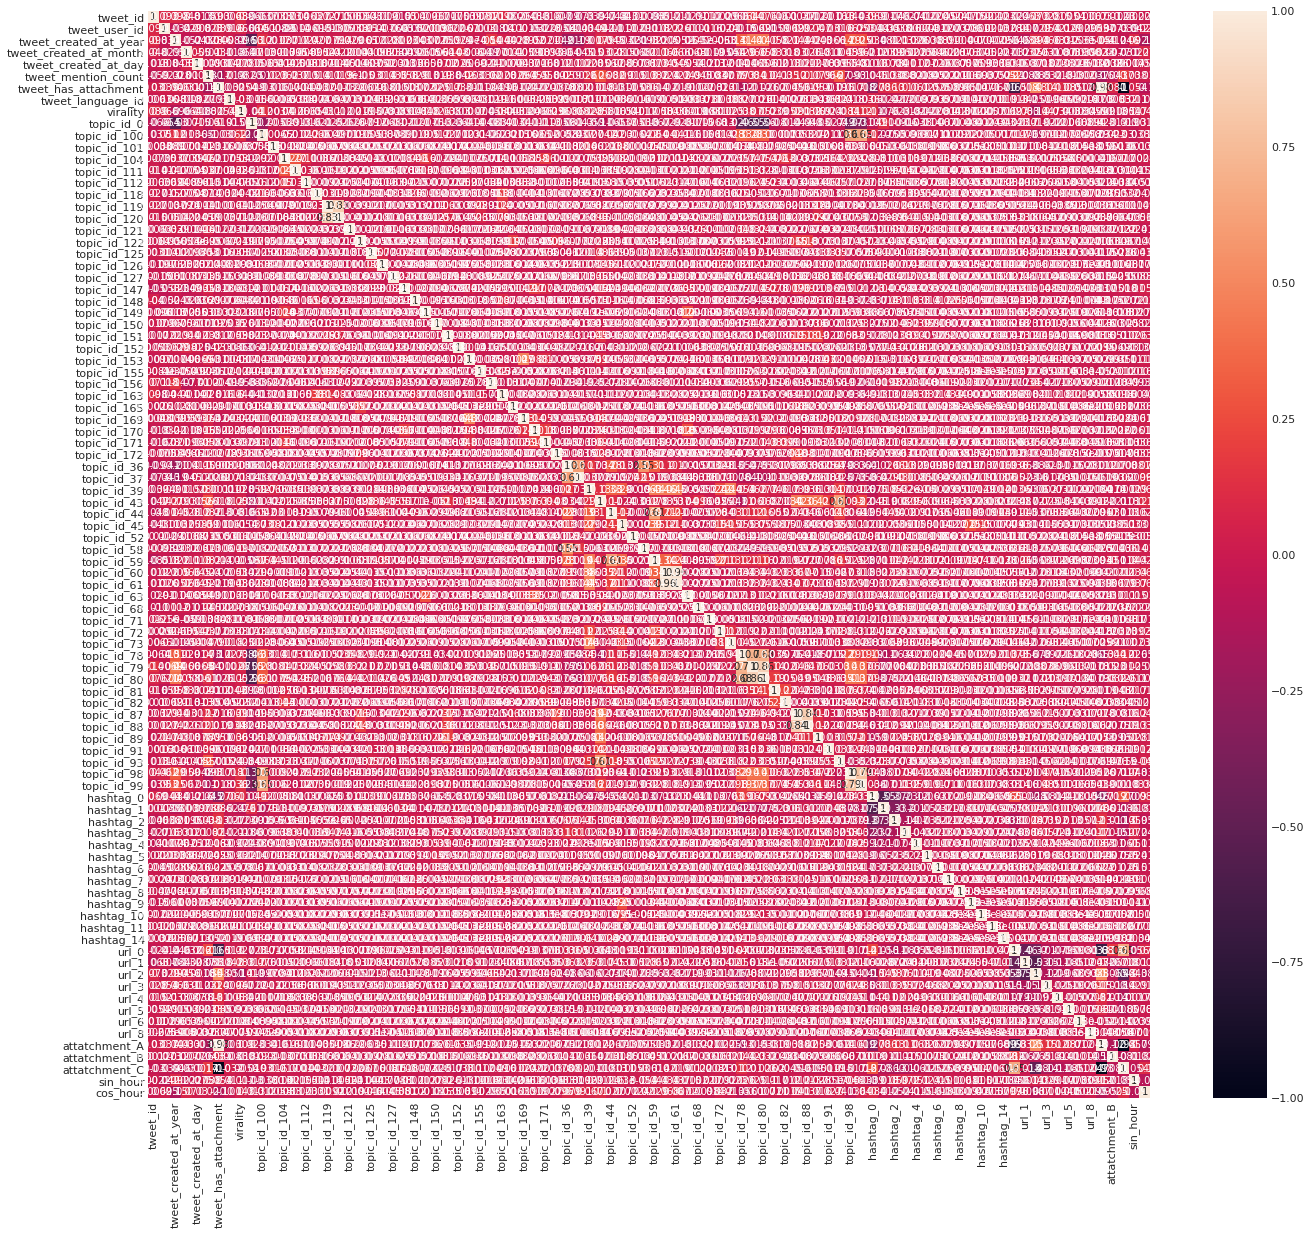

In [23]:
import seaborn as sns
plt.subplots(figsize = (20,20))
sns.heatmap(train_tweets_final.corr(),annot=True)

In [24]:
df_corr = train_tweets_final.corr()['virality'][2:-1]
top_features = df_corr.sort_values(ascending=False)
top_features

virality                  1.000000
topic_id_100              0.120685
topic_id_99               0.118466
topic_id_98               0.113526
hashtag_0                 0.113409
                            ...   
tweet_created_at_month   -0.063757
hashtag_1                -0.076472
tweet_mention_count      -0.081958
tweet_created_at_year    -0.096487
url_2                    -0.142122
Name: virality, Length: 89, dtype: float64

**Preprocessing User Tweets Data**

In [25]:
users.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6


In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


In [27]:
users.isnull().sum()

user_id                  0
user_like_count          0
user_followers_count     0
user_following_count     0
user_listed_on_count     0
user_has_location        0
user_tweet_count         0
user_has_url             0
user_verified            0
user_created_at_year     0
user_created_at_month    0
dtype: int64

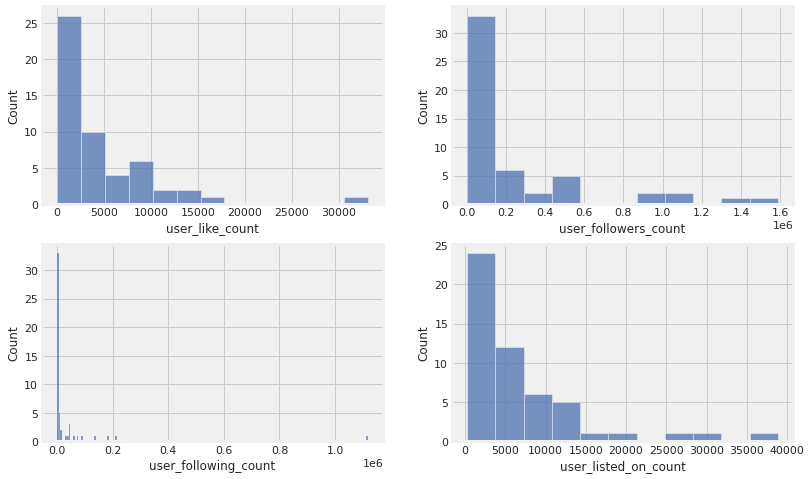

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(users, x = 'user_like_count', ax = axs[0,0]);
sns.histplot(users, x = 'user_followers_count', ax = axs[0,1]);
sns.histplot(users, x = 'user_following_count', ax = axs[1,0]);
sns.histplot(users, x = 'user_listed_on_count', ax = axs[1,1]);

<AxesSubplot:>

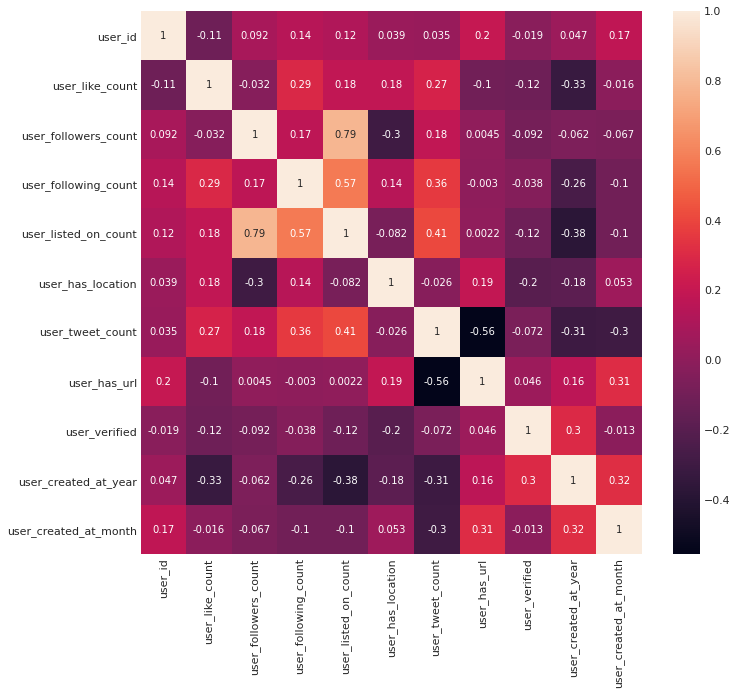

In [29]:
import seaborn as sns
plt.subplots(figsize = (10,10))
sns.heatmap(users.corr(),annot=True)

In [30]:
users.user_verified.unique()

array([0, 1])

In [31]:
#year = pd.get_dummies(users.user_created_at_year, prefix='year')
#month = pd.get_dummies(users.user_created_at_month , prefix='month')
user_verified = pd.get_dummies(users.user_verified, prefix='verified')

columns_drop = [
                #"user_created_at_year",
                #"user_created_at_month",
                #"user_verified"
              ]

dfs = [
        #year,
        #month,
        #user_verified
      ]

users_final = users.drop(columns_drop, 1).join(dfs)

users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6


In [32]:
'''cols = ['user_like_count', 'user_followers_count', 'user_following_count','user_listed_on_count','user_tweet_count']

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(standardize=False)

for col in cols:
    users_final[col] = pt.fit_transform(users_final[col].values.reshape(-1,1))'''

"cols = ['user_like_count', 'user_followers_count', 'user_following_count','user_listed_on_count','user_tweet_count']\n\nfrom sklearn.preprocessing import PowerTransformer\npt = PowerTransformer(standardize=False)\n\nfor col in cols:\n    users_final[col] = pt.fit_transform(users_final[col].values.reshape(-1,1))"

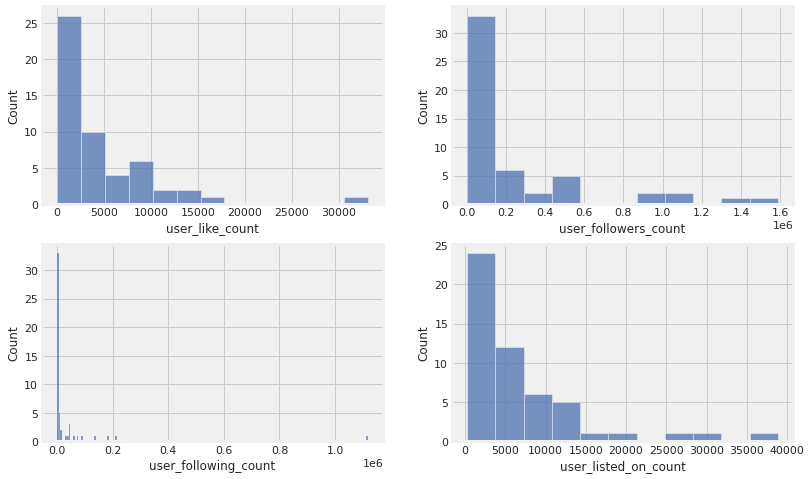

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(users_final, x = 'user_like_count', ax = axs[0,0]);
sns.histplot(users_final, x = 'user_followers_count', ax = axs[0,1]);
sns.histplot(users_final, x = 'user_following_count', ax = axs[1,0]);
sns.histplot(users_final, x = 'user_listed_on_count', ax = axs[1,1]);

In [34]:
#users_final['popularity'] = np.where((users_final['user_followers_count']-users_final['user_following_count'])>0 , 1, 0)

In [35]:
users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6


In [36]:
print("Train Tweets :", train_tweets_final.shape)
print("Users :", users_final.shape)

Train Tweets : (29625, 92)
Users : (52, 11)


**Train Tweet Vectorized Media**

In [37]:
# create new data frame that matches row number between train tweets and vectorized media
vectorized_media_df = pd.merge(train_tweets,train_tweets_vectorized_media, on ='tweet_id', how = 'right')
vectorized_media_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_media_df.head()

,virality,media_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,1,00001_00000,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,2,00004_00003,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,1,00005_00004,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,1,00008_00007,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,1,00009_00008,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


In [38]:
# Set the target as well as dependent variables from image data.
y = vectorized_media_df['virality']
x = vectorized_media_df.loc[:, vectorized_media_df.columns.str.contains("img_")] 

# Run Lasso regression for feature selection.
sel_model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  104.889950795


Counter({True: 2046, False: 2})

In [39]:
media_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_media_final = pd.concat([train_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
train_tweets_media_final.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,00009_00008,9,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


**Train Tweet Vectorized Text**

In [40]:
train_tweets.head(2)

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2,1,0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0,1,0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3


In [41]:
train_tweets_vectorized_text.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [42]:
# create new data frame that matches row number between train tweets and vectorized media
vectorized_text_df = pd.merge(train_tweets,train_tweets_vectorized_text, on ='tweet_id', how = 'right')
vectorized_text_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_text_df.head()

,virality,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,2,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,1,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,1,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [43]:
# Set the target as well as dependent variables from image data.
y = vectorized_text_df['virality']
x = vectorized_text_df.loc[:, vectorized_text_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  335.9880685659998


Counter({True: 678, False: 90})

In [44]:
text_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_text_final = pd.concat([train_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)
train_tweets_text_final.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


**User Vectorized Descriptions**

In [45]:
train_tweets.head(2)

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2,1,0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0,1,0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3


In [46]:
user_vectorized_descriptions.head(2)

,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,0.047779,...,0.238264,-0.315408,-0.159851,-0.00384,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,0.007423,...,0.232922,-0.314534,-0.177011,-0.04171,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693


In [47]:
average_virality_df =train_tweets.groupby('tweet_user_id').agg(pd.Series.median)['virality']

descriptions_df = pd.merge(average_virality_df, user_vectorized_descriptions, left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
profile_images_df = pd.merge(average_virality_df, user_vectorized_profile_images, left_on ='tweet_user_id', right_on = 'user_id', how = 'right')
descriptions_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,...,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,2,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,...,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,1,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,...,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,1,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,...,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,3,4,0.099192,-0.140809,-0.012423,-0.150097,-0.120169,0.054078,-0.384291,-0.269650,...,0.179307,-0.367725,-0.217667,-0.064391,0.163382,-0.020638,0.181554,-0.200262,-0.074513,0.037301


In [48]:
# Set the target as well as dependent variables from image data.
y = descriptions_df['virality']
x = descriptions_df.loc[:, descriptions_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.012462686999697326


Counter({False: 768})

In [49]:
desc_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_descriptions_final = pd.concat([user_vectorized_descriptions[['user_id']], desc_ind_df], axis=1)
user_descriptions_final.head()

,user_id
0,0
1,1
2,2
3,3
4,4


**User Vectorized Profile Images**

In [50]:
# Set the target as well as dependent variables from image data.
y = profile_images_df['virality']
x = profile_images_df.loc[:, profile_images_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.03211810500033607


Counter({False: 2002, True: 46})

In [51]:
user_prof_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_profile_images_final = pd.concat([user_vectorized_profile_images[['user_id']], user_prof_ind_df], axis=1)
user_profile_images_final.head()

,user_id,feature_17,feature_27,feature_40,feature_61,feature_72,feature_86,feature_173,feature_317,feature_414,...,feature_1791,feature_1813,feature_1816,feature_1822,feature_1864,feature_1918,feature_1922,feature_1950,feature_1961,feature_1969
0,0,0.119278,0.525636,0.900191,0.083202,0.329536,0.000521,0.000000,0.627162,0.091552,...,0.033612,0.107358,0.372768,0.007634,0.932529,0.114959,1.013090,0.649760,0.084254,1.045067
1,1,0.000000,0.117184,0.357163,0.095469,0.855587,0.198007,0.393067,1.099741,0.066106,...,0.133920,0.386295,0.014066,0.692967,0.749812,0.009956,0.044573,0.585450,0.136455,0.490154
2,2,0.000446,0.315113,0.409932,0.027620,1.140514,0.000000,0.000000,0.779874,0.061270,...,0.120005,0.069618,0.000000,0.077035,0.110357,0.041843,0.620970,0.327903,0.003597,0.305369
3,3,0.166473,0.024092,0.081909,0.005259,0.864800,0.000000,0.000000,0.739145,0.083874,...,0.184952,0.094760,0.046148,0.088233,0.332397,0.135303,0.062701,0.294951,0.000000,0.285678
4,4,0.349089,0.544103,1.188643,0.183290,0.792999,0.244120,0.246967,0.664849,0.181680,...,0.173362,0.026295,0.135455,0.000000,1.579148,0.016151,0.113244,0.672702,0.875126,0.149596


In [52]:
print(train_tweets_final.shape)
print(train_tweets_media_final.shape) # join on tweet id
print(train_tweets_text_final.shape) # join on tweet id
print(users_final.shape) # join on user_id
print(user_profile_images_final.shape) # join on user_id

(29625, 92)
(21010, 2048)
(29625, 679)
(52, 11)
(52, 47)


In [53]:
# media_df = train_tweets_media_final.groupby('tweet_id').mean()

In [54]:
# rename columns in tweets_vectorized_text

cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,...,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [55]:
# Merge all tables based on the column 'user_id' for user data, and tweet_id
# for tweet data

# join tweets data
#tweet_df = pd.merge(media_df, train_tweets_text_final, on = 'tweet_id', how = 'right')
#tweet_df.fillna(0, inplace=True)

# join users data
#user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# join tweets data on train_tweets
#tweet_df_final = pd.merge(train_tweets_final, tweet_df, on = 'tweet_id')

# join that with the users data
#final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

#final_df.shape

**Preprocessing Test Data**

In [56]:
test_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids
0,6238,13,2020,7,26,10,5.0,2.0,0.0,True,A,0,"['98', '99', '99', '99', '99', '78', '79', '80']"
1,37458,14,2018,1,15,18,0.0,0.0,1.0,False,C,0,"['78', '79', '80', '98']"
2,23968,50,2019,2,25,20,0.0,1.0,0.0,False,C,0,"['78', '79', '80']"
3,24137,50,2018,12,8,21,0.0,1.0,1.0,False,C,0,"['78', '79', '80']"
4,8064,30,2020,9,29,16,2.0,2.0,0.0,True,A,0,"['78', '79', '79', '80', '98', '99']"


In [57]:
test_tweets.isnull().sum()

tweet_id                     0
tweet_user_id                0
tweet_created_at_year        0
tweet_created_at_month       0
tweet_created_at_day         0
tweet_created_at_hour        0
tweet_hashtag_count          0
tweet_url_count              0
tweet_mention_count          0
tweet_has_attachment         0
tweet_attachment_class       0
tweet_language_id            0
tweet_topic_ids           1802
dtype: int64

In [58]:
test_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

In [59]:
# convert floats to ints
cols = ['tweet_hashtag_count', 'tweet_url_count', 'tweet_mention_count']
test_tweets[cols] = test_tweets[cols].applymap(np.int64)
test_tweets[cols].head()

,tweet_hashtag_count,tweet_url_count,tweet_mention_count
0,5,2,0
1,0,0,1
2,0,1,0
3,0,1,1
4,2,2,0


In [60]:
'''temp = test_tweets.groupby(['tweet_user_id']).agg({'tweet_id':['count'],
                                      'tweet_hashtag_count' : ['mean'],
                                      'tweet_url_count': ['mean'],
                                      'tweet_mention_count': ['mean']            
                                      })
temp.columns = ['_'.join(x) for x in temp.columns]
test_tweets = pd.merge(test_tweets,temp,on=['tweet_user_id'],how='left')'''

"temp = test_tweets.groupby(['tweet_user_id']).agg({'tweet_id':['count'],\n                                      'tweet_hashtag_count' : ['mean'],\n                                      'tweet_url_count': ['mean'],\n                                      'tweet_mention_count': ['mean']            \n                                      })\ntemp.columns = ['_'.join(x) for x in temp.columns]\ntest_tweets = pd.merge(test_tweets,temp,on=['tweet_user_id'],how='left')"

In [61]:
topic_ids = (
    test_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

#year = pd.get_dummies(test_tweets.tweet_created_at_year, prefix='year')
#month = pd.get_dummies(test_tweets.tweet_created_at_month , prefix='month')
#day = pd.get_dummies(test_tweets.tweet_created_at_day, prefix='day')
hashtag = pd.get_dummies(test_tweets.tweet_hashtag_count, prefix='hashtag')
url = pd.get_dummies(test_tweets.tweet_url_count, prefix='url')
#mention = pd.get_dummies(test_tweets.tweet_mention_count , prefix='mention')
attachment = pd.get_dummies(test_tweets.tweet_attachment_class, prefix='attatchment')
#language = pd.get_dummies(test_tweets.tweet_language_id, prefix='language')

## Cyclical encoding
sin_hour = np.sin(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
sin_hour.name = 'sin_hour'
cos_hour = np.cos(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
cos_hour.name = 'cos_hour'


columns_drop = [
                "tweet_topic_ids",
                #"tweet_created_at_year",
                #"tweet_created_at_month",
                #"tweet_created_at_day",
                "tweet_hashtag_count",
                "tweet_url_count",
                #"tweet_mention_count",
                "tweet_attachment_class",
                #"tweet_language_id",
                "tweet_created_at_hour",
              ]

dfs = [
        topic_ids,
        #year,
        #month,
        #day,
        hashtag,
        url,
        #mention,
        attachment,
        #language,
        sin_hour,
        cos_hour,
      ]

test_tweets_final = test_tweets.drop(columns_drop, 1).join(dfs)

test_tweets_final.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_mention_count,tweet_has_attachment,tweet_language_id,topic_id_0,topic_id_100,...,url_3,url_4,url_5,url_6,url_8,attatchment_A,attatchment_B,attatchment_C,sin_hour,cos_hour
0,6238,13,2020,7,26,0,True,0,0,0,...,0,0,0,0,0,1,0,0,0.500000,-8.660254e-01
1,37458,14,2018,1,15,1,False,0,0,0,...,0,0,0,0,0,0,0,1,-1.000000,-1.836970e-16
2,23968,50,2019,2,25,0,False,0,0,0,...,0,0,0,0,0,0,0,1,-0.866025,5.000000e-01
3,24137,50,2018,12,8,1,False,0,0,0,...,0,0,0,0,0,0,0,1,-0.707107,7.071068e-01
4,8064,30,2020,9,29,0,True,0,0,0,...,0,0,0,0,0,1,0,0,-0.866025,-5.000000e-01


In [62]:
len(train_tweets_final.columns) - len(test_tweets_final.columns) - 1 # virality column
# train is missing 11 columns from test

1

In [63]:
cols_test = set(test_tweets_final.columns) - set(train_tweets_final.columns)
cols_test # train is missing these 4 columns from test

{'topic_id_117', 'topic_id_123', 'topic_id_38'}

In [64]:
for col in cols_test:
    train_tweets_final[col] = 0

In [65]:
# columns missing in test from train
cols_test = set(train_tweets_final.columns) - set(test_tweets_final.columns)
cols_test.remove('virality') # remove virality from columsn to add to test
len(cols_test)

4

In [66]:
for col in cols_test:
    test_tweets_final[col] = 0

In [67]:
print("Train tweets Final Data : ",train_tweets_final.shape)
print("Test tweets Final Data : ",test_tweets_final.shape)

Train tweets Final Data :  (29625, 95)
Test tweets Final Data :  (12697, 94)


In [68]:
test_tweets_media_final = pd.concat([test_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
test_tweets_text_final = pd.concat([test_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)

media_df = test_tweets_media_final.groupby('tweet_id').mean()

cols = test_tweets_text_final.columns[test_tweets_text_final.columns.str.contains('feature_')]
test_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)

# join tweets data
# tweet_df = pd.merge(media_df, test_tweets_text_final, on = 'tweet_id', how = 'right')
# tweet_df.fillna(0, inplace=True)

# join users data
# user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# join tweets data on train_tweets
# tweet_df_final = pd.merge(test_tweets_final, tweet_df, on = 'tweet_id')

# join that with the users data
# p_final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

# p_final_df.shape

In [69]:
#final_df.to_csv("new_train.csv",index=False)
#p_final_df.to_csv("new_test.csv",index=False)

#from IPython.display import FileLink
#FileLink(r'new_train.csv')
#FileLink(r'new_test.csv')

**Data Grouping**

**Training Data**

In [70]:
train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_mention_count,tweet_has_attachment,tweet_language_id,virality,topic_id_0,...,url_6,url_8,attatchment_A,attatchment_B,attatchment_C,sin_hour,cos_hour,topic_id_38,topic_id_123,topic_id_117
0,34698,10,2015,12,5,0,False,0,3,0,...,0,0,0,0,1,0.707107,0.707107,0,0,0
1,24644,4,2020,6,19,0,False,0,3,0,...,0,0,0,0,1,0.000000,1.000000,0,0,0
2,36321,54,2019,6,2,0,True,0,1,0,...,0,0,1,0,0,-0.707107,-0.707107,0,0,0
3,2629,42,2020,9,6,1,True,0,2,0,...,0,0,1,0,0,-0.965926,-0.258819,0,0,0
4,28169,32,2020,11,4,0,True,0,2,0,...,0,0,1,0,0,-0.965926,-0.258819,0,0,0


In [71]:
users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month
0,0,1164,48720,70469,5956,True,14122,True,0,2010,8
1,1,3914,85361,2171,5943,False,6957,False,0,2011,9
2,2,8292,200944,1416,8379,True,83485,True,0,2011,6
3,3,1770,15385,4572,1866,True,12265,True,0,2011,8
4,4,15311,459083,1021,7368,False,121193,False,0,2011,6


In [72]:
#final_df = pd.merge(train_tweets_final, users_final, left_on = 'tweet_user_id', right_on='user_id')

**Dimesionality Reduction for Train Tweets Text Final**

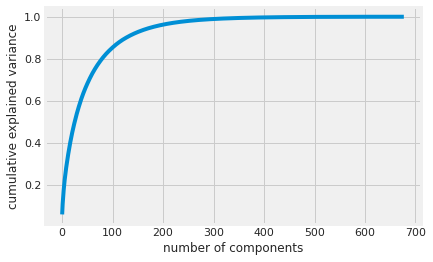

In [73]:
from sklearn.decomposition import PCA
pca = PCA().fit(train_tweets_text_final.drop(['tweet_id'],axis=1))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 25)

#Training data
pc = pca.fit_transform(train_tweets_text_final.drop(['tweet_id'],axis=1))
principal_train_tweets_text_final = pd.DataFrame(data = pc )
principal_train_tweets_text_final = principal_train_tweets_text_final.add_prefix('text_')

In [75]:
principal_train_tweets_text_final['tweet_id'] = train_tweets_text_final['tweet_id']

# final_df = pd.merge(final_df, principal_train_tweets_text_final, on = 'tweet_id')

In [76]:
principal_train_tweets_text_final.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,...,text_16,text_17,text_18,text_19,text_20,text_21,text_22,text_23,text_24,tweet_id
0,0.137442,-0.447254,-0.108076,0.053682,0.283341,-0.120829,-0.187765,0.189928,0.128767,0.005359,...,-0.089205,-0.329765,-0.030222,0.093493,-0.004938,0.098799,0.060700,-0.017959,-0.305580,0
1,-0.498374,-0.008947,0.206030,-0.422111,-0.098172,0.113430,-0.149266,0.216022,-0.121494,-0.076744,...,-0.017540,-0.206504,0.126444,0.088255,0.064238,-0.080517,0.062851,0.053847,-0.014877,1
2,-0.280123,-0.104966,-0.029595,0.001720,0.144074,0.358128,-0.002458,-0.131723,-0.102566,0.105473,...,0.139433,-0.201372,0.188193,0.100518,-0.196046,0.077210,0.069424,0.139275,-0.028178,4
3,-0.413468,-0.300137,0.081873,-0.465491,-0.006092,-0.096819,0.397271,0.146337,-0.228622,0.043801,...,-0.075388,0.229917,-0.022790,-0.041289,-0.240312,-0.064334,0.118466,-0.121767,0.178235,5
4,-0.392224,0.047845,-0.057247,-0.352931,-0.030731,0.345173,0.221144,0.019283,-0.158756,0.098331,...,-0.130988,-0.218665,0.263906,0.037995,-0.205640,0.230840,0.047272,-0.100490,0.047269,8


**Dimesionality Reduction for Train Tweets Media Final**

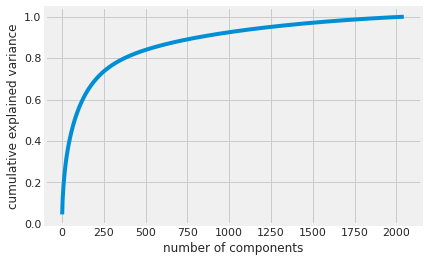

In [77]:
pca1 = PCA().fit(train_tweets_media_final.drop(['tweet_id','media_id'],axis=1))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [78]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components = 10)

#Training data
pc1 = pca1.fit_transform(train_tweets_media_final.drop(['tweet_id','media_id'],axis=1))
principal_train_tweets_media_final = pd.DataFrame(data = pc1)
principal_train_tweets_media_final = principal_train_tweets_media_final.add_prefix('media_')

In [79]:
principal_train_tweets_media_final['tweet_id'] = train_tweets_media_final['tweet_id']

In [80]:
media_df = principal_train_tweets_media_final.groupby('tweet_id').mean()

In [81]:
media_df.head()

,media_0,media_1,media_2,media_3,media_4,media_5,media_6,media_7,media_8,media_9
tweet_id,,,,,,,,,,
1,0.229429,0.947764,1.613904,0.674597,-0.066706,2.710319,-0.807520,0.401240,-0.706869,0.740667
4,4.926400,0.943465,-0.011357,0.076451,-0.630098,0.062672,-0.486443,0.055926,0.051705,0.190761
5,3.876033,0.877707,-0.778130,0.345040,-0.709768,-0.154372,-0.711101,2.509674,1.271330,-1.209418
8,2.785799,0.714973,3.808761,-0.804861,1.242206,-0.153961,0.047369,0.707291,0.420546,-0.376882
9,3.050307,0.924081,3.717271,-1.744783,1.222970,-0.693148,-0.803958,0.610673,1.198489,-0.146034


**Dimesionality Reduction for User Profile Images**

In [82]:
user_profile_images_final.head()

,user_id,feature_17,feature_27,feature_40,feature_61,feature_72,feature_86,feature_173,feature_317,feature_414,...,feature_1791,feature_1813,feature_1816,feature_1822,feature_1864,feature_1918,feature_1922,feature_1950,feature_1961,feature_1969
0,0,0.119278,0.525636,0.900191,0.083202,0.329536,0.000521,0.000000,0.627162,0.091552,...,0.033612,0.107358,0.372768,0.007634,0.932529,0.114959,1.013090,0.649760,0.084254,1.045067
1,1,0.000000,0.117184,0.357163,0.095469,0.855587,0.198007,0.393067,1.099741,0.066106,...,0.133920,0.386295,0.014066,0.692967,0.749812,0.009956,0.044573,0.585450,0.136455,0.490154
2,2,0.000446,0.315113,0.409932,0.027620,1.140514,0.000000,0.000000,0.779874,0.061270,...,0.120005,0.069618,0.000000,0.077035,0.110357,0.041843,0.620970,0.327903,0.003597,0.305369
3,3,0.166473,0.024092,0.081909,0.005259,0.864800,0.000000,0.000000,0.739145,0.083874,...,0.184952,0.094760,0.046148,0.088233,0.332397,0.135303,0.062701,0.294951,0.000000,0.285678
4,4,0.349089,0.544103,1.188643,0.183290,0.792999,0.244120,0.246967,0.664849,0.181680,...,0.173362,0.026295,0.135455,0.000000,1.579148,0.016151,0.113244,0.672702,0.875126,0.149596


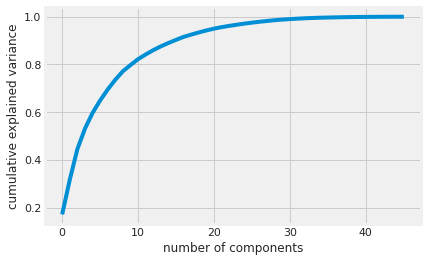

In [83]:
from sklearn.decomposition import PCA
pca2 = PCA().fit(user_profile_images_final.drop(['user_id'],axis=1))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [84]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components = 10)

#Training data
pc2 = pca2.fit_transform(user_profile_images_final.drop(['user_id'],axis=1))
principal_user_profile_images_final = pd.DataFrame(data = pc2)
principal_user_profile_images_final = principal_user_profile_images_final.add_prefix('userprofile_')

In [85]:
principal_user_profile_images_final['user_id'] = user_profile_images_final['user_id']

In [86]:
principal_user_profile_images_final.head()

,userprofile_0,userprofile_1,userprofile_2,userprofile_3,userprofile_4,userprofile_5,userprofile_6,userprofile_7,userprofile_8,userprofile_9,user_id
0,-0.754989,0.496370,0.564883,0.019570,0.019308,0.317681,-0.115082,0.254279,-0.070077,0.259697,0
1,0.302680,0.284623,-1.079815,-0.163143,0.178227,0.071119,-0.136643,-0.084482,-0.357786,-0.012284,1
2,1.150890,-1.134941,0.635248,0.531280,-0.226046,0.971905,0.226514,-0.202865,0.777531,-0.006041,2
3,1.391246,-1.497287,0.065006,0.056703,0.220895,0.591637,-0.359666,-0.301720,0.356741,0.107312,3
4,-0.940193,0.417223,0.793663,1.524091,0.188080,-0.566581,-0.525493,0.586599,-0.245055,-0.037905,4


In [87]:
#tweet_df = pd.merge(media_df, principal_train_tweets_text_final, on = 'tweet_id', how = 'right')
#tweet_df.fillna(0, inplace=True)

user_df = pd.merge(users_final, principal_user_profile_images_final, on='user_id')
tweet_df_final = pd.merge(train_tweets_final, principal_train_tweets_text_final, on = 'tweet_id')

final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

In [88]:
final_df.shape

(29625, 141)

**Testing Data**

In [89]:
test_tweets_final.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_mention_count,tweet_has_attachment,tweet_language_id,topic_id_0,topic_id_100,...,url_8,attatchment_A,attatchment_B,attatchment_C,sin_hour,cos_hour,topic_id_165,hashtag_14,hashtag_10,hashtag_11
0,6238,13,2020,7,26,0,True,0,0,0,...,0,1,0,0,0.500000,-8.660254e-01,0,0,0,0
1,37458,14,2018,1,15,1,False,0,0,0,...,0,0,0,1,-1.000000,-1.836970e-16,0,0,0,0
2,23968,50,2019,2,25,0,False,0,0,0,...,0,0,0,1,-0.866025,5.000000e-01,0,0,0,0
3,24137,50,2018,12,8,1,False,0,0,0,...,0,0,0,1,-0.707107,7.071068e-01,0,0,0,0
4,8064,30,2020,9,29,0,True,0,0,0,...,0,1,0,0,-0.866025,-5.000000e-01,0,0,0,0


In [90]:
#p_final_df = pd.merge(test_tweets_final, users_final, left_on = 'tweet_user_id', right_on='user_id')

**Dimesionality Reduction for Test Tweets Text Final**

In [91]:
#Testing data
pc = pca.transform(test_tweets_text_final.drop(['tweet_id'],axis=1))
principal_test_tweets_text_final = pd.DataFrame(data = pc )
principal_test_tweets_text_final = principal_test_tweets_text_final.add_prefix('text_')

principal_test_tweets_text_final['tweet_id'] = test_tweets_text_final['tweet_id']

In [92]:
# p_final_df = pd.merge(p_final_df, principal_test_tweets_text_final, on = 'tweet_id')

**Dimesionality Reduction for Test Tweets media Final**

In [93]:
#Testing data
pc1 = pca1.transform(test_tweets_media_final.drop(['tweet_id','media_id'],axis=1))
principal_test_tweets_media_final = pd.DataFrame(data = pc1 )
principal_test_tweets_media_final = principal_test_tweets_media_final.add_prefix('media_')

In [94]:
principal_test_tweets_media_final.head()

,media_0,media_1,media_2,media_3,media_4,media_5,media_6,media_7,media_8,media_9
0,0.229427,0.947790,1.613923,0.673027,-0.062188,2.706326,-0.801162,0.395242,-0.692492,0.738032
1,4.926400,0.943450,-0.011357,0.076941,-0.631043,0.061537,-0.486747,0.057208,0.048262,0.199168
2,3.876033,0.877694,-0.778215,0.345570,-0.709716,-0.155780,-0.710967,2.507094,1.268926,-1.210949
3,2.785799,0.714975,3.808735,-0.805245,1.241744,-0.154084,0.044999,0.705566,0.414084,-0.386552
4,3.050306,0.924092,3.717269,-1.744966,1.224497,-0.694129,-0.804121,0.608813,1.198697,-0.152898


In [95]:
principal_test_tweets_media_final['tweet_id'] = test_tweets_media_final['tweet_id']

media_df = principal_test_tweets_media_final.groupby('tweet_id').mean()

In [96]:
#tweet_df = pd.merge(media_df, principal_test_tweets_text_final, on = 'tweet_id', how = 'right')
#tweet_df.fillna(0, inplace=True)

tweet_df_final = pd.merge(test_tweets_final, principal_test_tweets_text_final, on = 'tweet_id')
p_final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

In [97]:
print(final_df.shape , p_final_df.shape)

(29625, 141) (12697, 140)


**Building Model**

In [98]:
X = final_df.drop(['virality','tweet_id','user_id'], axis=1)
y = final_df['virality']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (20737, 138)
Test set shape  (8888, 138)


**Logistic Regression**

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix as cm

lr = LogisticRegression()
lr.fit(X_train,y_train)

#prediction on the test dataset
y_pred_lr = lr.predict(X_test)

accuracy = accuracy_score(y_pred_lr, y_test)
print('Logistic Regression accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_lr)))

Logistic Regression accuracy score: 0.5234


In [100]:
print("----------Confusion Matrix Logistic Regression---------\n")
print(cm(y_test,y_pred_lr))

----------Confusion Matrix Logistic Regression---------

[[3776  172  113    0    0]
 [1938  442  266    0    0]
 [ 619  386  434    0    0]
 [ 143   98   77    0    0]
 [ 125  139  160    0    0]]


**Random Forest**

In [101]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

#prediction on the test dataset
y_pred_rfc = rfc.predict(X_test)


accuracy = accuracy_score(y_pred_rfc, y_test)
print('Random Forest Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_rfc)))

Random Forest Model accuracy score: 0.6727


In [102]:
print("----------Confusion Matrix Random Forest---------\n")
print(cm(y_test,y_pred_rfc))

----------Confusion Matrix Random Forest---------

[[3615  429   13    0    4]
 [ 941 1364  333    0    8]
 [ 166  403  805   18   47]
 [  36   62  159   13   48]
 [  42   64  123   13  182]]


**Light GBM**

In [103]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

#prediction on the test dataset
y_pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6656


In [104]:
print("----------Confusion Matrix Light GBM---------\n")
print(cm(y_test,y_pred))

----------Confusion Matrix Light GBM---------

[[3599  433   22    3    4]
 [ 929 1383  328    3    3]
 [ 152  444  751   38   54]
 [  33   67  155   16   47]
 [  35   83  120   19  167]]


In [105]:
print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))

Precision score: 64.18%


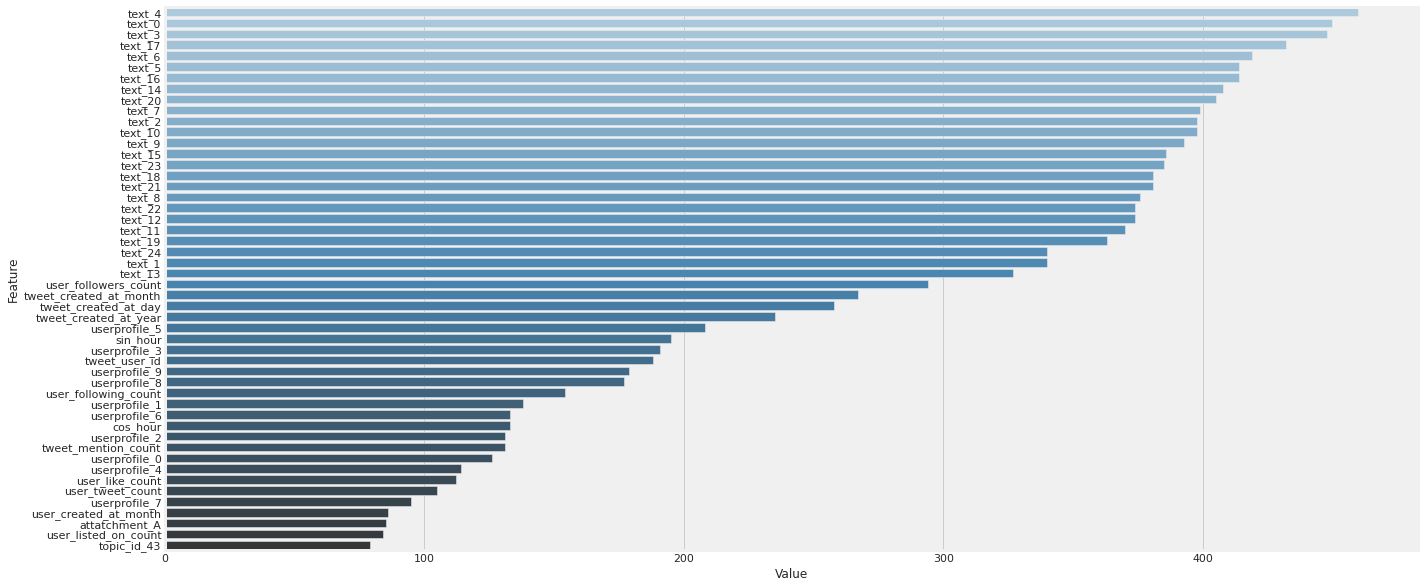

In [106]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50], palette="Blues_d");

**CatBoost**

In [107]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

m = CatBoostClassifier(n_estimators=5000,random_state=1994,eval_metric='Accuracy',learning_rate=0.03,max_depth=5)
m.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_test, y_test)],early_stopping_rounds=200,verbose=200)

print(accuracy_score(m.predict(X_test),y_test))


0:	learn: 0.5795438	test: 0.5795438	test1: 0.5696445	best: 0.5696445 (0)	total: 111ms	remaining: 9m 13s
200:	learn: 0.6559290	test: 0.6559290	test1: 0.6477273	best: 0.6477273 (199)	total: 11.2s	remaining: 4m 27s
400:	learn: 0.6712157	test: 0.6712157	test1: 0.6541404	best: 0.6543654 (391)	total: 21.1s	remaining: 4m 2s
600:	learn: 0.6824517	test: 0.6824517	test1: 0.6572907	best: 0.6575158 (597)	total: 30.7s	remaining: 3m 44s
800:	learn: 0.6919516	test: 0.6919516	test1: 0.6612286	best: 0.6614536 (784)	total: 41.1s	remaining: 3m 35s
1000:	learn: 0.7026089	test: 0.7026089	test1: 0.6640414	best: 0.6640414 (1000)	total: 50.6s	remaining: 3m 22s
1200:	learn: 0.7116266	test: 0.7116266	test1: 0.6643789	best: 0.6651665 (1173)	total: 1m	remaining: 3m 10s
1400:	learn: 0.7188118	test: 0.7188118	test1: 0.6653915	best: 0.6660666 (1326)	total: 1m 10s	remaining: 3m 1s
1600:	learn: 0.7272026	test: 0.7272026	test1: 0.6667417	best: 0.6675293 (1482)	total: 1m 20s	remaining: 2m 50s
Stopped by overfitting dete

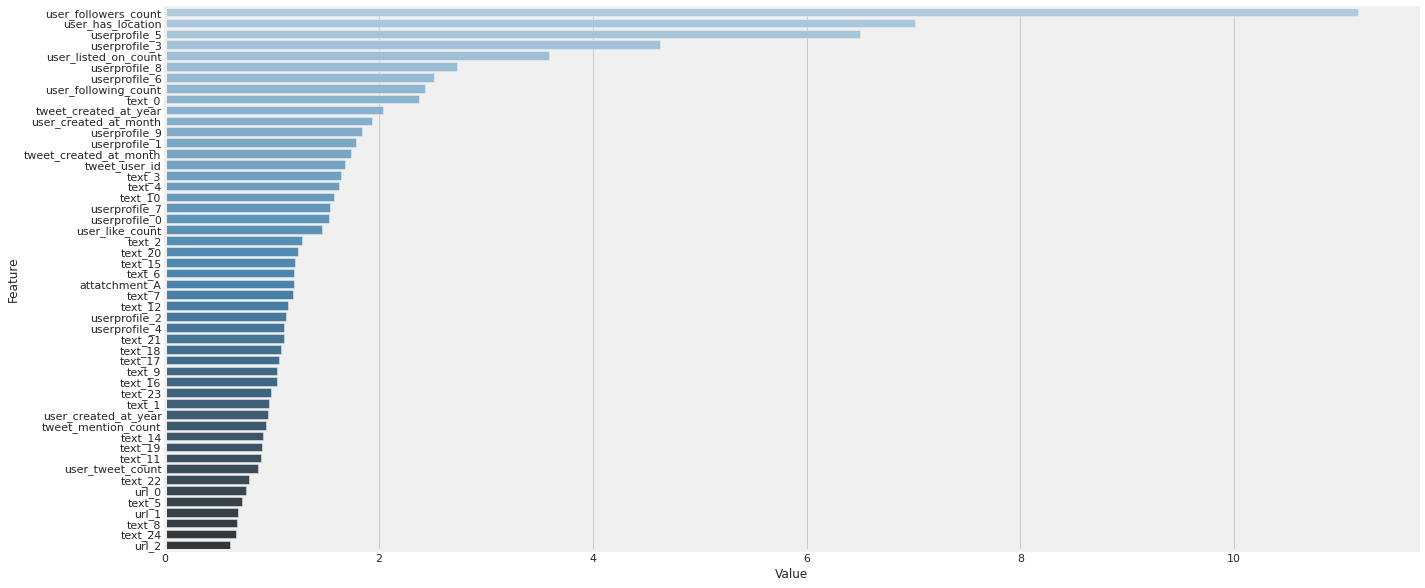

In [108]:
feature_imp = pd.DataFrame(sorted(zip(m.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50], palette="Blues_d");

**Extra Tree Classifier**

In [109]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators =700, max_depth =100)
etc.fit(X_train, y_train)

#prediction on the test dataset
y_pred = etc.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print('ETC Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

ETC Model accuracy score: 0.6795


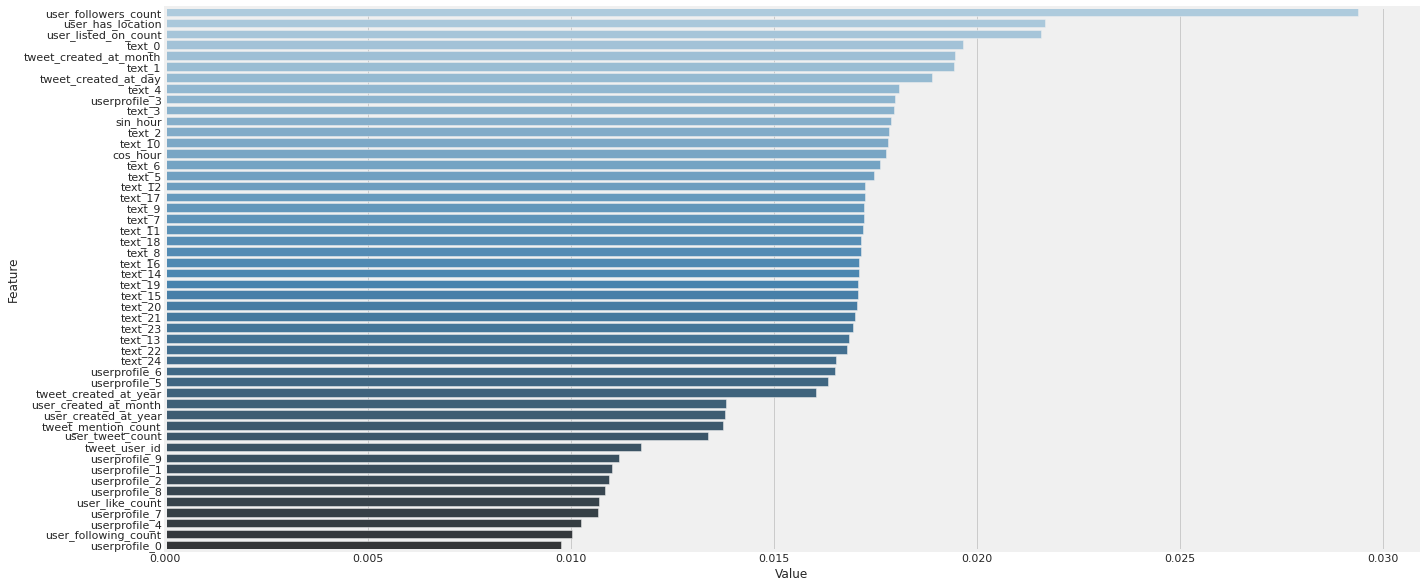

In [110]:
feature_imp = pd.DataFrame(sorted(zip(etc.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:50], palette="Blues_d");

**Stack Ensemble**

In [111]:
'''from sklearn.ensemble import StackingClassifier
estimator=[("light gbm",clf),("catboost",m), ("etc",etc)]
sc = StackingClassifier(estimators=estimator)

sc.fit(X_train,y_train)

#prediction on the test dataset
y_pred = sc.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print('Stacking Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))'''

'from sklearn.ensemble import StackingClassifier\nestimator=[("light gbm",clf),("catboost",m), ("etc",etc)]\nsc = StackingClassifier(estimators=estimator)\n\nsc.fit(X_train,y_train)\n\n#prediction on the test dataset\ny_pred = sc.predict(X_test)\n\nfrom sklearn.metrics import accuracy_score\naccuracy = accuracy_score(y_pred, y_test)\nprint(\'Stacking Model accuracy score: {0:0.4f}\'.format(accuracy_score(y_test, y_pred)))'

**Model Fitting on Testing Data**

In [112]:
p_final_df.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_mention_count,tweet_has_attachment,tweet_language_id,topic_id_0,topic_id_100,...,userprofile_0,userprofile_1,userprofile_2,userprofile_3,userprofile_4,userprofile_5,userprofile_6,userprofile_7,userprofile_8,userprofile_9
0,6238,13,2020,7,26,0,True,0,0,0,...,1.657874,-0.14475,-0.712976,-0.758245,-0.260822,-0.085113,0.161677,0.748052,-0.825106,0.379009
1,6334,13,2020,6,21,2,True,0,0,0,...,1.657874,-0.14475,-0.712976,-0.758245,-0.260822,-0.085113,0.161677,0.748052,-0.825106,0.379009
2,5822,13,2021,1,8,0,False,0,0,0,...,1.657874,-0.14475,-0.712976,-0.758245,-0.260822,-0.085113,0.161677,0.748052,-0.825106,0.379009
3,6260,13,2020,7,20,1,False,0,0,0,...,1.657874,-0.14475,-0.712976,-0.758245,-0.260822,-0.085113,0.161677,0.748052,-0.825106,0.379009
4,6162,13,2020,8,20,2,False,0,0,0,...,1.657874,-0.14475,-0.712976,-0.758245,-0.260822,-0.085113,0.161677,0.748052,-0.825106,0.379009


In [113]:
test = p_final_df.drop(['tweet_id','user_id'], axis=1)

solution = m.predict(test)
solution_df = pd.concat([p_final_df[['tweet_id']], pd.DataFrame(solution, columns = ['virality'])], axis=1)
solution_df.head()

,tweet_id,virality
0,6238,1
1,6334,1
2,5822,1
3,6260,1
4,6162,1


In [114]:
test_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids
0,6238,13,2020,7,26,10,5,2,0,True,A,0,"['98', '99', '99', '99', '99', '78', '79', '80']"
1,37458,14,2018,1,15,18,0,0,1,False,C,0,"['78', '79', '80', '98']"
2,23968,50,2019,2,25,20,0,1,0,False,C,0,"['78', '79', '80']"
3,24137,50,2018,12,8,21,0,1,1,False,C,0,"['78', '79', '80']"
4,8064,30,2020,9,29,16,2,2,0,True,A,0,"['78', '79', '79', '80', '98', '99']"


In [115]:
# join tweets data on train_tweets
sub1 = pd.merge(test_tweets, solution_df, on = 'tweet_id')

In [116]:
sub1 = sub1[['tweet_id','virality']]
sub1.head()

,tweet_id,virality
0,6238,1
1,37458,1
2,23968,5
3,24137,5
4,8064,3


In [117]:
sub1.to_csv("solution20.csv",index=False)

In [118]:
from IPython.display import FileLink
FileLink(r'solution20.csv')

/kaggle/working/solution20.csv